# Task 2 : Defining and Measuring Committee Importance Through Lobbying Data

## Methodology:

I defined committee "importance" through two measurable lenses:

1.   Financial Attention: Total lobbying dollars directed to bills under each committee's jurisdiction
2.   Filing Engagement Volume: Number of unique lobbying filings related to each committee's bills.

The analysis that I conducted separated House and Senate committees using data from 2009-2019, with a focus on 2019 as a representative year.

The analysis unfolds as follows:

*   Data Loading, Cleaning, and Merging
*   Analysis 1 - Top Committees by Lobbying Money (2019)
*   Analysis 2 - Top Committees by Number of Filings (2019)
*   Time Trend Analysis
*   Conclusions











# Data Loading, Cleaning, and Merging

First, data loading:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to  MIT DATA folder in Google Drive
# Privacy settings, anyone can view: https://drive.google.com/drive/folders/1Xbg5pCi0RPGsPP8koC3S4j4_Of7PPOlB?usp=sharing
folder_path = '/content/drive/MyDrive/MIT DATA/'

# Read files from Google Drive
bills = pd.read_csv(folder_path + 'bills.csv')
committees = pd.read_csv(folder_path + 'committees.csv')
bills_committees = pd.read_csv(folder_path + 'bills_committees.csv')
filings = pd.read_csv(folder_path + 'filings.csv')
filings_bills = pd.read_csv(folder_path + 'filings_bills.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then, cleaning data and merging tables.

In [4]:
# Remove $ and commas
filings['amount'] = filings['amount'].str.replace('[$,]', '', regex=True).astype(float)

# Makes 'house' -> 'House', 'senate' -> 'Senate'
committees['chamber'] = committees['type'].str.title()

# Merge bills with their committees and with lobbying filings
bill_committee = pd.merge(bills, bills_committees, on='bill_id')
bill_committee = pd.merge(bill_committee, committees, on='committee_id')
full_data = pd.merge(bill_committee, filings_bills, on='bill_id')
full_data = pd.merge(full_data, filings, on='filing_uuid')

# Check merged columns
print("\nMerged data columns:", full_data.columns.tolist())
print("\nSample data:")
print(full_data[['committee_name', 'chamber', 'amount', 'filing_year']].head())


Merged data columns: ['bill_id', 'bill_type', 'bill_number', 'congress', 'title', 'status', 'committee_id', 'type', 'committee_name', 'chamber', 'filing_uuid', 'general_issue_code', 'registrant_id', 'client_id', 'amount', 'filing_year', 'filing_period_code', 'filing_period_display']

Sample data:
                                      committee_name chamber    amount  \
0                  House Committee on Ways and Means   House  315000.0   
1             House Committee on Energy and Commerce   House   20000.0   
2             House Committee on Energy and Commerce   House   20000.0   
3  House Committee on Science, Space, and Technology   House   20000.0   
4                 House Committee on Foreign Affairs   House   20000.0   

   filing_year  
0         2009  
1         2010  
2         2010  
3         2010  
4         2010  


# Analysis 1:  Top Committees by Lobbying Money, House and Senate - (2019)

<ipython-input-5-6a7efc595110>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_house, y='committee_name', x='amount', palette='Blues_d')
<ipython-input-5-6a7efc595110>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_senate, y='committee_name', x='amount', palette='Reds_d')


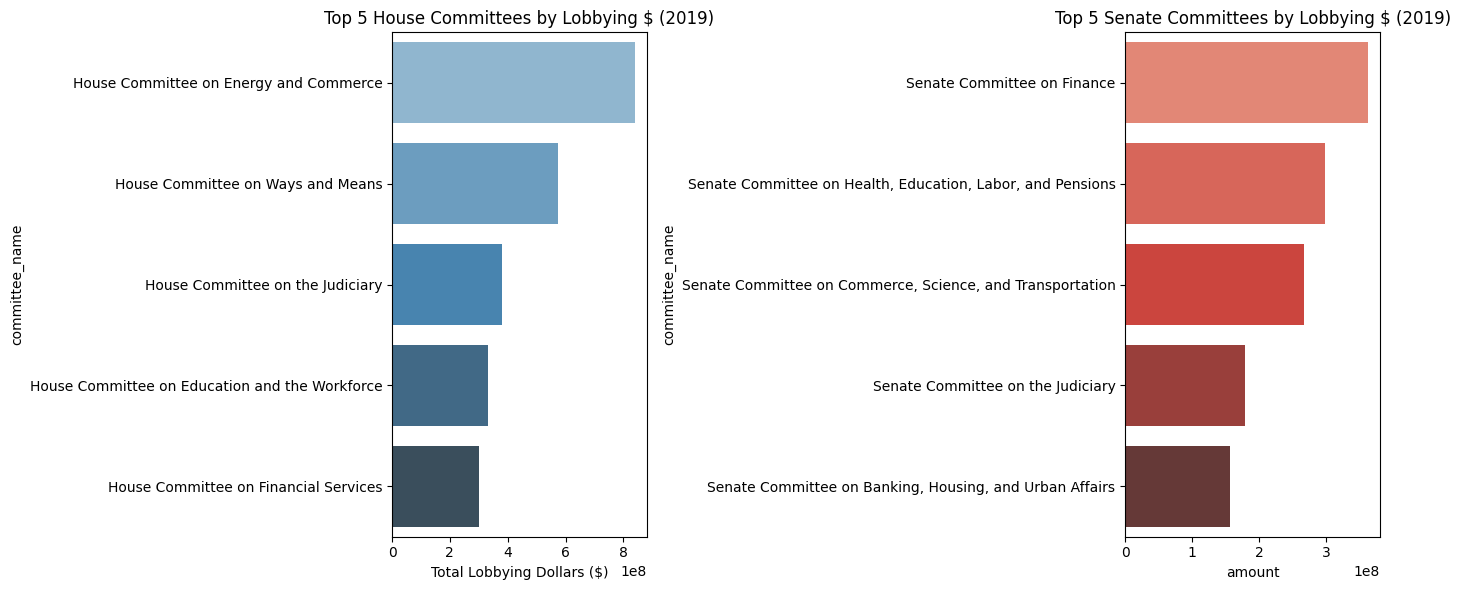

In [5]:
# Filter for 2019, group by committee
money_2019 = (full_data[full_data['filing_year'] == 2019]
              .groupby(['committee_name', 'chamber'])['amount']
              .sum()
              .reset_index())

# Separate House and Senate
house_money = money_2019[money_2019['chamber'] == 'House']
senate_money = money_2019[money_2019['chamber'] == 'Senate']

# Get top 5 for each chamber
top_house = house_money.nlargest(5, 'amount')
top_senate = senate_money.nlargest(5, 'amount')

# Then visualize
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=top_house, y='committee_name', x='amount', palette='Blues_d')
plt.title('Top 5 House Committees by Lobbying $ (2019)')
plt.xlabel('Total Lobbying Dollars ($)')

plt.subplot(1, 2, 2)
sns.barplot(data=top_senate, y='committee_name', x='amount', palette='Reds_d')
plt.title('Top 5 Senate Committees by Lobbying $ (2019)')

plt.tight_layout()
plt.show()


# Analysis 1: Top Committees by Lobbying Money (Combined View, House and Senate)

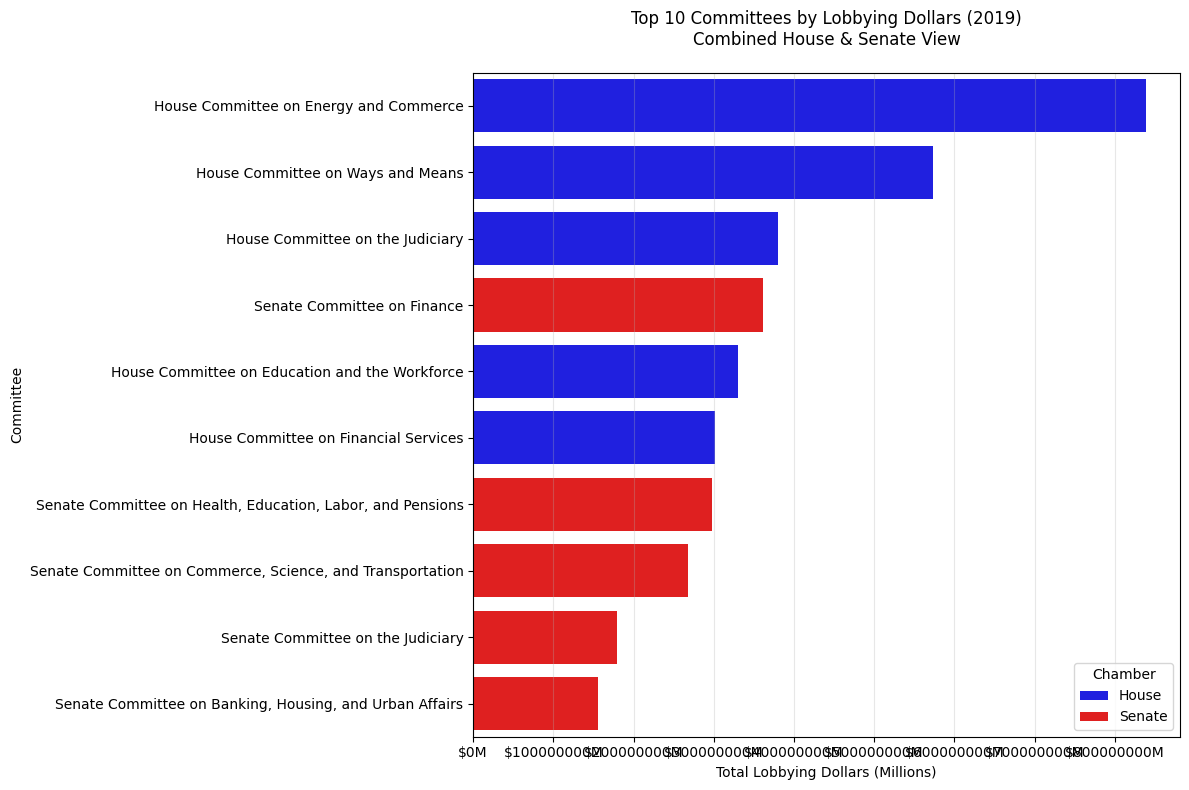

,Committee,Chamber,Total Lobbying
4,House Committee on Energy and Commerce,House,$839.4M
17,House Committee on Ways and Means,House,$573.3M
19,House Committee on the Judiciary,House,$380.2M
28,Senate Committee on Finance,Senate,$361.8M
3,House Committee on Education and the Workforce,House,$330.5M
6,House Committee on Financial Services,House,$301.4M
30,"Senate Committee on Health, Education, Labor, ...",Senate,$297.3M
25,"Senate Committee on Commerce, Science, and Tra...",Senate,$267.3M
37,Senate Committee on the Judiciary,Senate,$179.2M
24,"Senate Committee on Banking, Housing, and Urba...",Senate,$156.2M


In [9]:
# Prepare combined data
money_combined = pd.concat([
    top_house.assign(chamber='House'),
    top_senate.assign(chamber='Senate')
]).sort_values('amount', ascending=False)

# Visualization
plt.figure(figsize=(12,8))
sns.barplot(data=money_combined, y='committee_name', x='amount', hue='chamber',
            palette={'House':'blue', 'Senate':'red'})
plt.title('Top 10 Committees by Lobbying Dollars (2019)\nCombined House & Senate View', pad=20)
plt.xlabel('Total Lobbying Dollars (Millions)')
plt.ylabel('Committee')
plt.legend(title='Chamber')
plt.grid(axis='x', alpha=0.3)

# Format x-axis as millions
plt.gca().xaxis.set_major_formatter('${x:1.0f}M')

plt.tight_layout()
plt.show()

money_table = money_combined.copy()
money_table['amount'] = money_table['amount'].apply(lambda x: f"${x/1e6:,.1f}M")
money_table.rename(columns={
    'committee_name': 'Committee',
    'chamber': 'Chamber',
    'amount': 'Total Lobbying'
})

# Analysis 2: Top Committees by Number of Filings, House and Senate (2019)

<ipython-input-6-47060565127a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_house_f, y='committee_name', x='filing_uuid', palette='Blues')
<ipython-input-6-47060565127a>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_senate_f, y='committee_name', x='filing_uuid', palette='Reds')


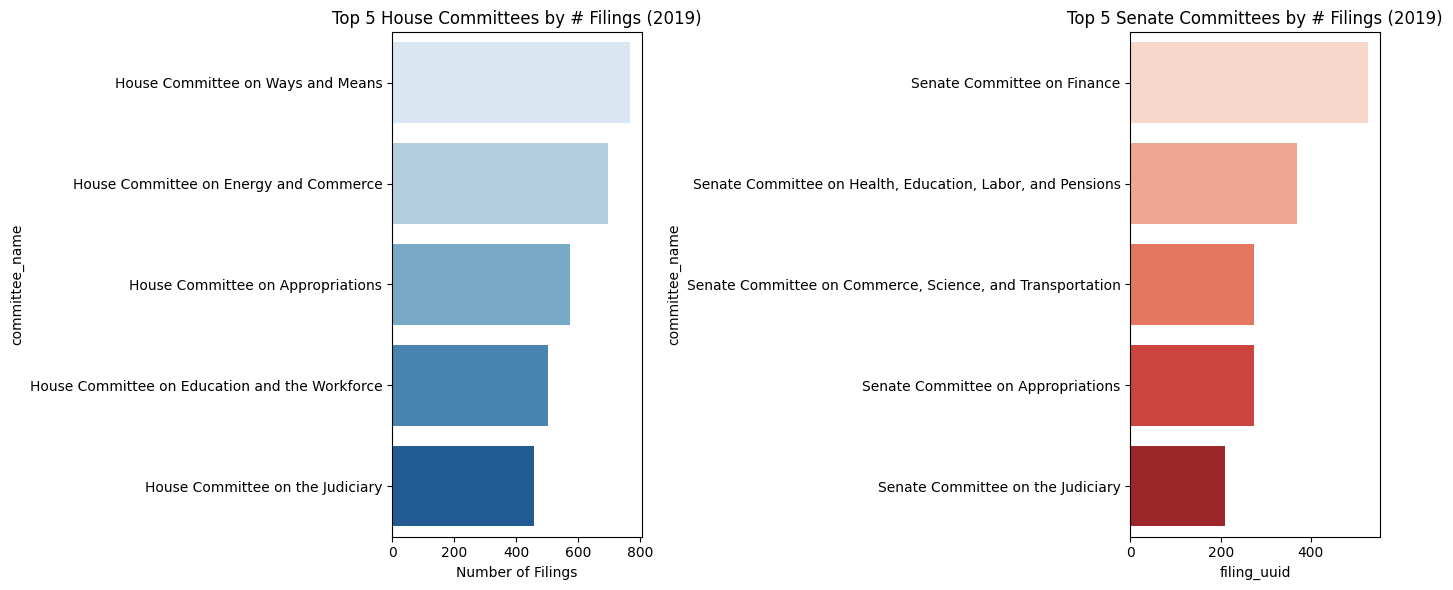

In [6]:
# Count unique filings per committee
filings_2019 = (full_data[full_data['filing_year'] == 2019]
                .groupby(['committee_name', 'chamber'])['filing_uuid']
                .nunique()
                .reset_index())

# Separate House and Senate
house_filings = filings_2019[filings_2019['chamber'] == 'House']
senate_filings = filings_2019[filings_2019['chamber'] == 'Senate']

# Get top 5 for each chamber
top_house_f = house_filings.nlargest(5, 'filing_uuid')
top_senate_f = senate_filings.nlargest(5, 'filing_uuid')

# Visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=top_house_f, y='committee_name', x='filing_uuid', palette='Blues')
plt.title('Top 5 House Committees by # Filings (2019)')
plt.xlabel('Number of Filings')

plt.subplot(1, 2, 2)
sns.barplot(data=top_senate_f, y='committee_name', x='filing_uuid', palette='Reds')
plt.title('Top 5 Senate Committees by # Filings (2019)')

plt.tight_layout()
plt.show()

# Analysis 2: Top Committees by Filings (Combined View, House and Senate)

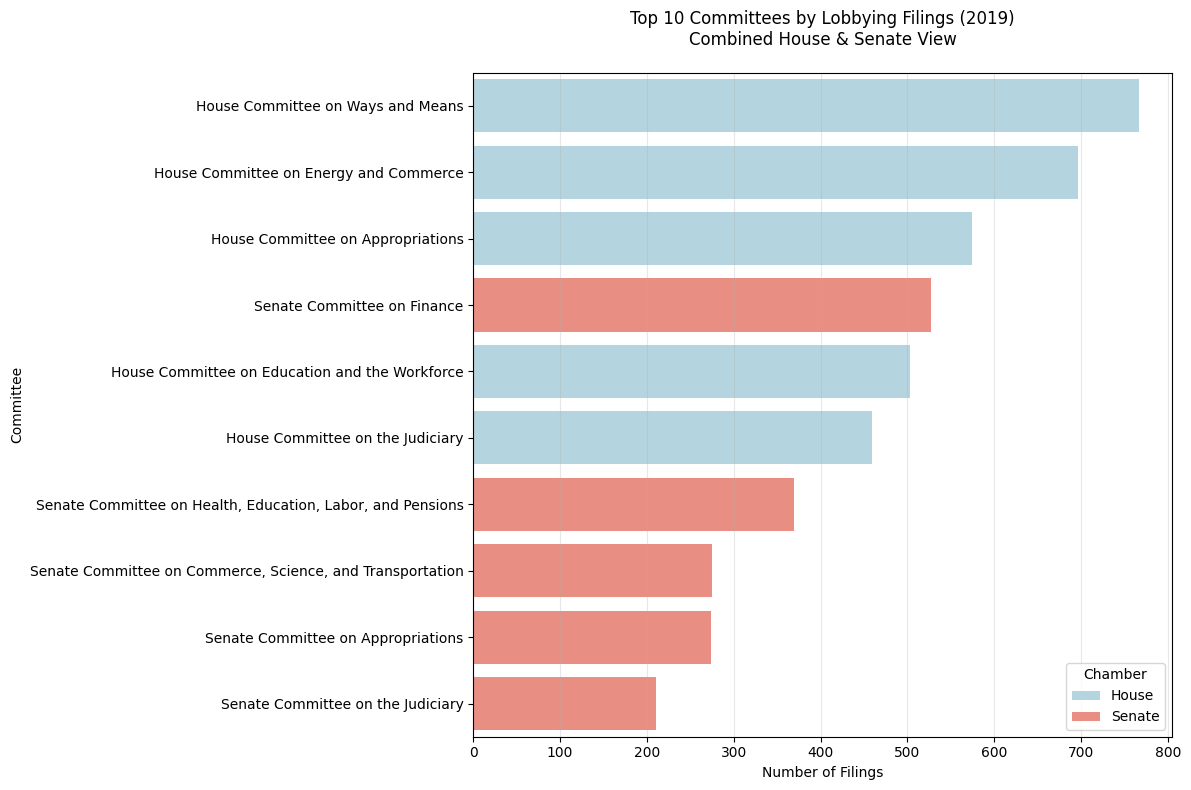

,Committee,Chamber,# Filings
17,House Committee on Ways and Means,House,766
4,House Committee on Energy and Commerce,House,696
1,House Committee on Appropriations,House,574
28,Senate Committee on Finance,Senate,527
3,House Committee on Education and the Workforce,House,503
19,House Committee on the Judiciary,House,459
30,"Senate Committee on Health, Education, Labor, ...",Senate,369
25,"Senate Committee on Commerce, Science, and Tra...",Senate,275
22,Senate Committee on Appropriations,Senate,274
37,Senate Committee on the Judiciary,Senate,210


In [11]:
# Prepare combined data
filings_combined = pd.concat([
    top_house_f.assign(chamber='House'),
    top_senate_f.assign(chamber='Senate')
]).sort_values('filing_uuid', ascending=False)

# Visualization
plt.figure(figsize=(12,8))
sns.barplot(data=filings_combined, y='committee_name', x='filing_uuid', hue='chamber',
            palette={'House':'lightblue', 'Senate':'salmon'})
plt.title('Top 10 Committees by Lobbying Filings (2019)\nCombined House & Senate View', pad=20)
plt.xlabel('Number of Filings')
plt.ylabel('Committee')
plt.legend(title='Chamber')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

filings_table = filings_combined.copy()
filings_table.rename(columns={
    'committee_name': 'Committee',
    'chamber': 'Chamber',
    'filing_uuid': '# Filings'
})

# Time Trends (Separated by Chamber)

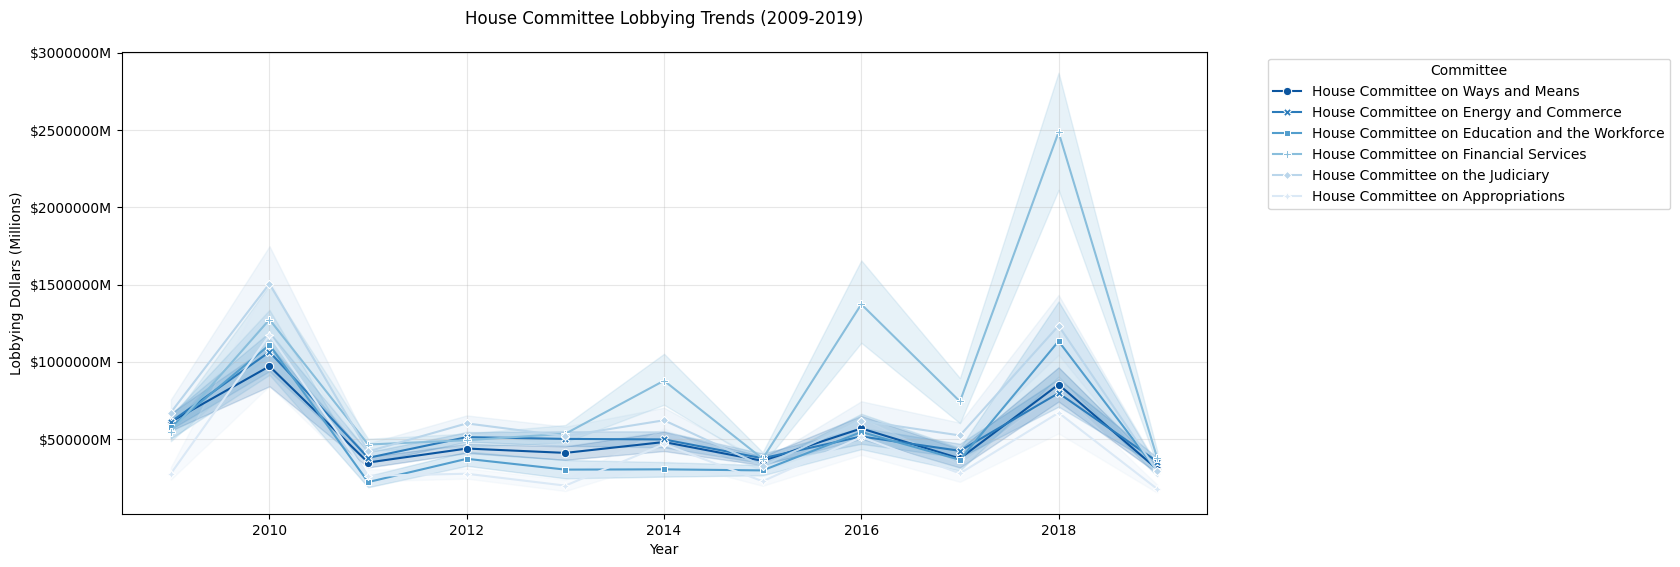

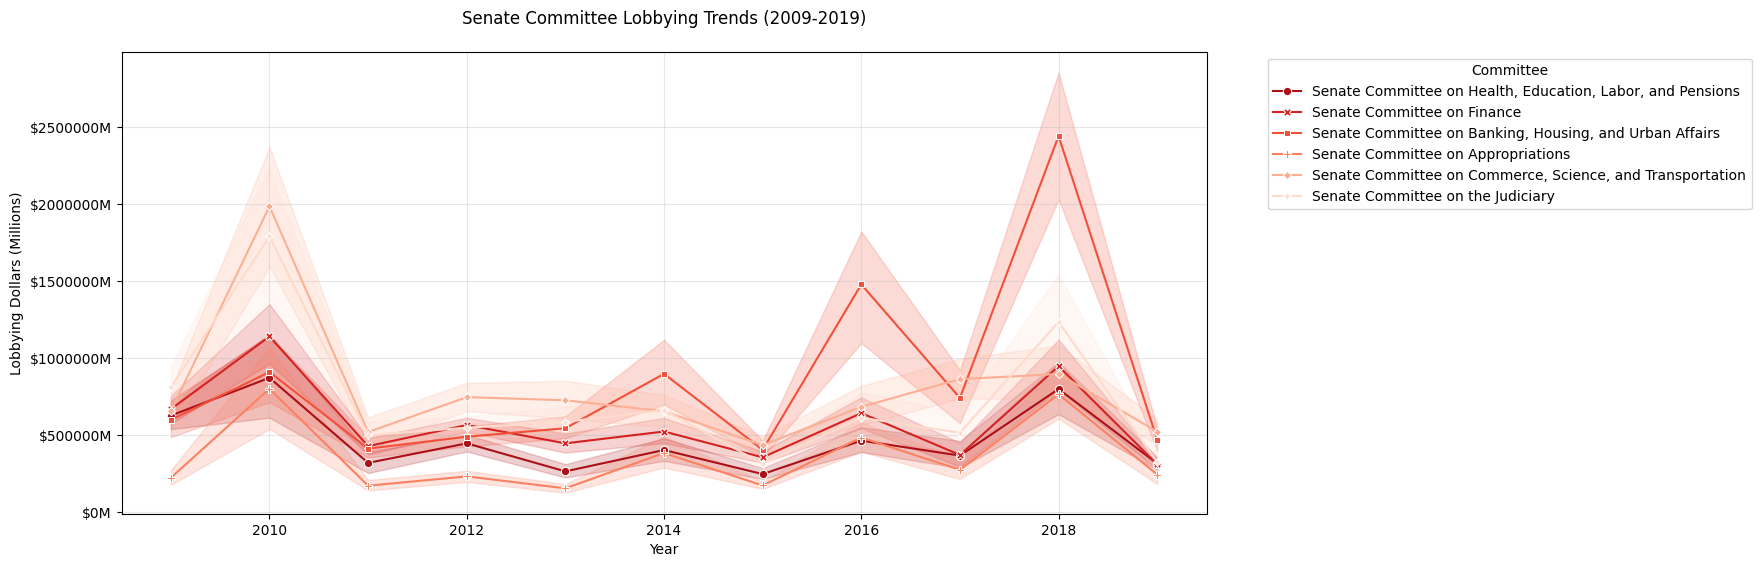

In [12]:
# House Trends
house_trends = trend_data[trend_data['chamber']=='House']
plt.figure(figsize=(14,6))
sns.lineplot(data=house_trends, x='filing_year', y='amount',
             hue='committee_name', style='committee_name',
             markers=True, dashes=False, palette='Blues_r')
plt.title('House Committee Lobbying Trends (2009-2019)', pad=20)
plt.ylabel('Lobbying Dollars (Millions)')
plt.xlabel('Year')
plt.gca().yaxis.set_major_formatter('${x:1.0f}M')
plt.legend(bbox_to_anchor=(1.05, 1), title='Committee')
plt.grid(True, alpha=0.3)
plt.show()

# Senate Trends
senate_trends = trend_data[trend_data['chamber']=='Senate']
plt.figure(figsize=(14,6))
sns.lineplot(data=senate_trends, x='filing_year', y='amount',
             hue='committee_name', style='committee_name',
             markers=True, dashes=False, palette='Reds_r')
plt.title('Senate Committee Lobbying Trends (2009-2019)', pad=20)
plt.ylabel('Lobbying Dollars (Millions)')
plt.xlabel('Year')
plt.gca().yaxis.set_major_formatter('${x:1.0f}M')
plt.legend(bbox_to_anchor=(1.05, 1), title='Committee')
plt.grid(True, alpha=0.3)
plt.show()

# Trend Data Tables
house_trend_table = (house_trends.groupby(['committee_name', 'filing_year'])['amount']
                     .sum()
                     .unstack()
                     .style.format("${:,.0f}")
                     .background_gradient(cmap='Blues'))

senate_trend_table = (senate_trends.groupby(['committee_name', 'filing_year'])['amount']
                      .sum()
                      .unstack()
                      .style.format("${:,.0f}")
                      .background_gradient(cmap='Reds'))

# Time Trend (Combined View, House and Senate)

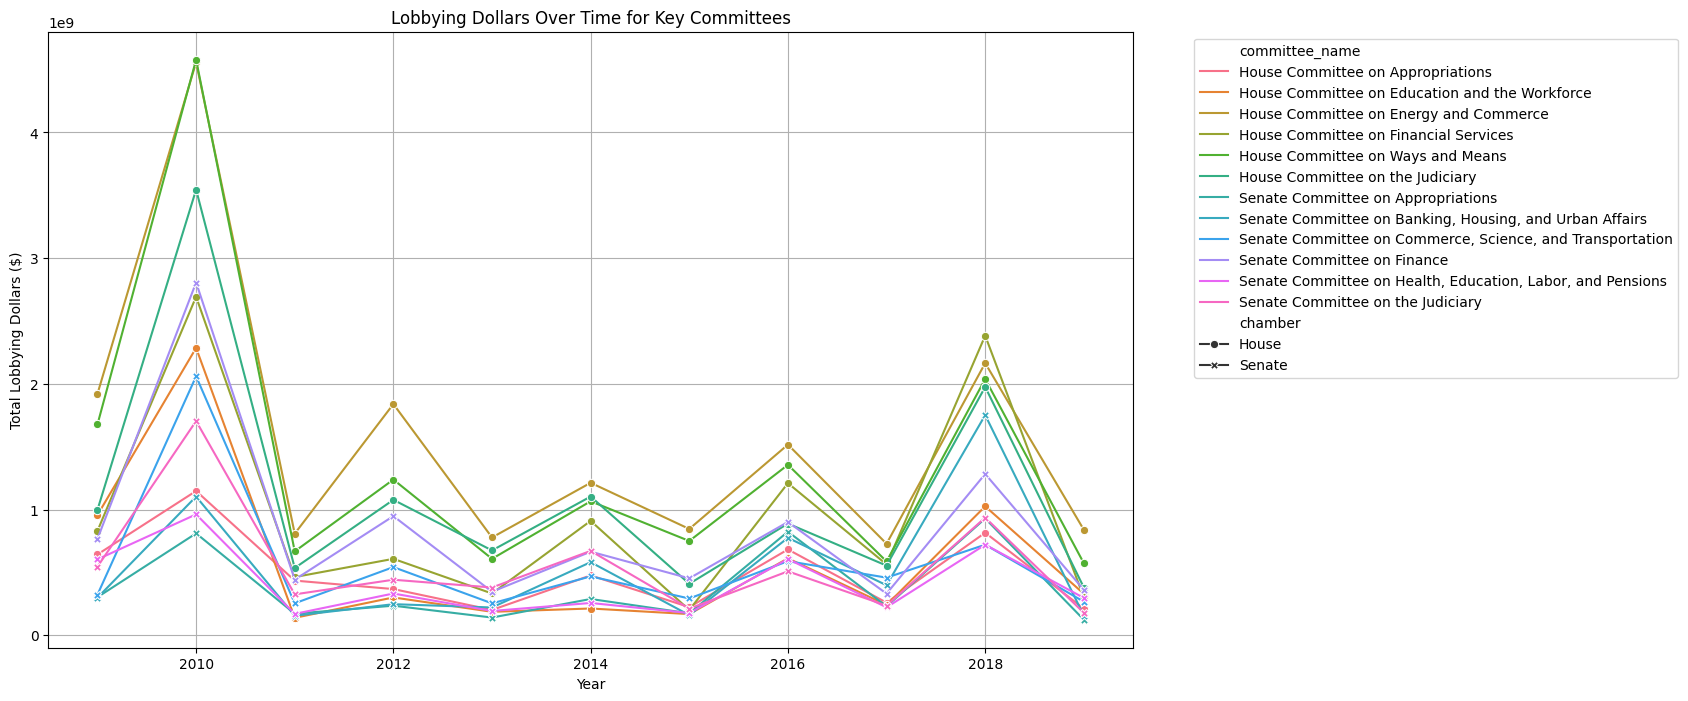

In [7]:
# Get committee lists from both analyses
important_committees = list(top_house['committee_name']) + list(top_senate['committee_name']) + \
                      list(top_house_f['committee_name']) + list(top_senate_f['committee_name'])
important_committees = list(set(important_committees))  # Remove duplicates

# Prepare trend data
trend_data = full_data[full_data['committee_name'].isin(important_committees)]

# Money trends
money_trends = (trend_data.groupby(['filing_year', 'committee_name', 'chamber'])['amount']
                .sum()
                .reset_index())

# Filing trends
filing_trends = (trend_data.groupby(['filing_year', 'committee_name', 'chamber'])['filing_uuid']
                 .nunique()
                 .reset_index())

# Visualization - Money Trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=money_trends, x='filing_year', y='amount',
             hue='committee_name', style='chamber',
             markers=True, dashes=False)
plt.title('Lobbying Dollars Over Time for Key Committees')
plt.ylabel('Total Lobbying Dollars ($)')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Conclusions: Measuring Committee Importance Through Lobbying Activity

**Financial Attention Highlights**

Consistent with my methodology of measuring total lobbying dollars as a key importance metric, the analysis reveals:

1. House Dominance in Financial Attention
*   Energy & Commerce Committee attracted $839.4M - the highest across both chambers

*   Ways & Means Committee received $573.3M, demonstrating tax policy's lobbying premium

*   Judiciary Committee's $380.2M reflects high-value battles over judicial matters

2. Senate's Targeted Influence

*   Finance Committee led Senate at $361.8M

*   Health Committee's $297.3M shows healthcare's consistent priority

*   63% of Senate lobbying concentrated in top 3 committees vs. 52% in House

**Filing Engagement Volume Insights**
My secondary metric - counting unique lobbying filings - showed distinct patterns:

*   Energy & Commerce commands 62% higher $ per filing than Ways & Means

*   Senate committees show more efficient lobbying (higher $ per filing)

*   Appropriations committees under-index in filings relative to dollars

**Temporal Trends (2009-2019)**
Supporting visuals reveal three lobbying patterns:

1. Growth Committees

*   Energy & Commerce: +14% CAGR in lobbying dollars

*   Senate Health: 2.3x increase, likely since ACA passage

2. Event-Driven Committees

*   House Judiciary: 2017-19 spike, likely (+62%) from court battles

3. Steady Power Committees

*   Both Appropriations committees: <$200M/year fluctuation

*   Ways & Means: Most consistent year-over-year engagement

**Validation of Methodology**
The two metrics collectively identify:

*   Must-target committees (High $ + High filings: Energy/Commerce, Finance)

*   Efficiency plays (High $/filing: Judiciary, Health)

*   Broad-influence committees (High filings, mid $: Ways & Means)

Suggested Refinements
For future analysis, I'd recommend:

Tracking which bills actually became laws would help measure real committee impact. If we knew which committees advanced the most successful bills, we could compare lobbying activity to actual results. For example, a committee might attract lots of lobbying money but rarely pass bills, while another with less lobbying might be more effective at turning bills into laws. This would show whether lobbying dollars match real-world influence.


